# Note
## 20230331
mod-(reg)-BPDN可以转化为一个二次规划问题, 用qp()解决.
`cvxopt.solvers.qp()`
## 20230401
建议不要过度封装. 每个算法尽量展开写出.另外不要过度输出,可以只输出信号估计,而误差等可以不输出,而是改为在别的地方重新计算.|尝试加入haltingRule=('rIterErr',eps), 但不会以这种封装的方式, 而是针对个别算法.|以后要测试算法性能,考虑收敛时(因此要用'rIterErr'停机判定)取得的误差最小值,以及达到收敛需要的迭代次数.总的来看,'rIterErr'可能是比'rSampErr'更好的停机判据.
## 20230402
大改代码. 把算法统一到各自的功能中,去掉多余的参数,例如先知信号等.将停机法则统一为相对更新率收敛至`eps=1e-6`.由于要比较迭代次数,可以设置可选输出`returnIter=True`.
题目含有'Exec!'的为直接可执行代码区域,注意绕开.
## 20230404
把所有向量维数统一为`n`,之后可能的时间序列长度记为`N`.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations as cb
import cvxopt

# 1 预备函数
## 1.1 随机采样阵生成

In [2]:
# 随机采样阵生成
def randSampMat(m,n):
    """
    Return m*n sampling matrix.
    Use type `np.float32`.
    """
    #用高斯分布抽样, 列单位化.
    A = np.random.randn(m,n).astype(np.float32)
    for j in range(A.shape[1]):
        A[:,j] = A[:,j] / np.sqrt(A[:,j].dot(A[:,j]))
    return A

## 1.2 共轭梯度法
(Iterative) Conjugate gradient method.

In [3]:
def conjGrad(A,b,maxIter=-1,x="0",eps=1e-6,showChangeRate=False):
    """
    迭代的共轭梯度法. 要求A实正定对称.
    `x`:初始点.
    收敛相对误差|Δx[t]|/|x[t-1]|被`eps`控制.
    方法优点: 迭代至多进行k=len(b)次. A事先计算出,控制迭代次数,则复杂度O(k^2).
    不吝啬迭代则O(k^3).
    """
    k = A.shape[0] # 行/列数。
    if maxIter==-1:
        maxIter = k
    if x=='0':
        x = np.zeros(k)
    r = b - np.dot(A,x)
    p = r
    r2old = r.dot(r)
    for i in range(maxIter):
        Ap = A.dot(p)
        alpha = r2old / (p.dot(Ap))
        xOld = x
        x = x + alpha * p
        r = r - alpha * Ap
        r2new = r.dot(r)
        changeRate = np.sqrt((x-xOld).dot(x-xOld)/(eps**2 + x.dot(x)))
            #相对迭代误差(改进率).
        if showChangeRate:
            print('Iter',i,':',changeRate)
        if changeRate < eps:
            break
        p = r + (r2new/r2old)*p
        r2old = r2new
    return x

## 1.3 限制等距常数估计

In [4]:
# RIP测试.
class RIPtest:
    def __init__(self,A,s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 2 methods:
            `RIPtest(A,s).monteCarlo(nVec,show)`: Monte Carlo method;
            `RIPtest(A,s).singularValue()`: singularValue method.
        """
        self.A = A
        self.s = s
    #         
    # 
    # 
    #                 
    # Monte-Carlo method.
    def monteCarlo(self, nVec=1e5, show=True): # 这是一个对象方法.
        # def fun() 是类方法; def fun(self) 是对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. 
        `nVec`: Number of vectors to test. 
        `show`: Whether to draw the distribution of amplifications.

        Running time:
            O(nVec=10000,n=10000,m=400)~70sec;
            
            O(nVec=5000,n=5000,m=200)~10sec;

            O(nVec=100000,n=200,m=50)~3sec.
        """
        
        n = self.A.shape[1]
        nVec = int(nVec) # 转化形如`1e5`的输入.
        V =  np.zeros((n,nVec),order='F',dtype=np.float32) # 由多个s-稀疏的列向量组成. 
        Supps = np.array([np.random.choice(range(n),self.s,replace=False) for i in range(nVec)])
            # 随机抽取支集, 存为每一行.
        Entries = np.array([np.random.randn(self.s).astype(np.float32) for i in range(nVec)])
            # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j],j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A,V)
            # 象.
        Amplifications = np.array(list(map(lambda v:np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications); delta1 = ampMax-1
        ampMin = np.min(Amplifications); delta2 = 1-ampMin
        delta = max(delta1,delta2)

        if show==True:
        # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0],ThreeSigmaPoints[1],100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications,bins=100,density=True,label='Amplifications')
            plt.plot(Xnorm,Ynorm,'r:',label='Gaussian Reference')
            plt.axvline(ThreeSigmaPoints[0],linestyle='-.',color='g',label='-3 sigma')
            plt.axvline(ThreeSigmaPoints[1],linestyle='--',color='m',label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1-ThreeSigmaPoints[0],ThreeSigmaPoints[1]-1))
            
            if delta==delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:",side)
        return delta
    #
    #
    #
    # SingularValue method.
    def singularValue(self, SAFECODE, showSingularValues=True, mode='memory-saving'):
        """
        有内存泄漏危险, 勿用!

        确认使用时输入参数`SAFECODE=CONFIRM`.

        Return delta_s.

        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices.
        
        Running time:
            `mode='memory-saving'`: O(n=200,m=20,s=3)~30sec; O(n=2000,m=20,s=2)~39sec; O(n=2000,m=20,s=3)~ >5min.
            
            `mode='fast'`: O(n=200,m=20,s=3)~23sec; O(n=2000,m=20,s=2)~27sec; O(n=2000,m=20,s=3)~ >2min(MemoryError).
        
        建议:
            1, 采用分布式计算, 因为耗时关于s指数级增长;
            
            2, 改用Monte-Carlo方法, 其估计概率已足够大;
            
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """

        if SAFECODE!='CONFIRM':
            print('Not safe!')
            return
        
        n = self.A.shape[1]

        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode=='memory-saving':
            PtrCombinations = cb(range(n),self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.linalg.svd(self.A[:,ptr])[1] 
                    # `Svs` for 'Singular Values'.
                    # Only accept float32+ type.
                maxSv = max(np.max(Svs),maxSv)
                minSv = min(np.min(Svs),minSv)

        # ↑↓ 以空间换时间.
        elif mode=='fast':
            Submatrices = np.array(list(cb(self.A.transpose(),self.s)))

            # Svs = np.array(list(map(np.linalg.svd,
            #           Submatrices))).reshape(1,-1)[0]
            # ↑↓ Equivalent.
            Svs = np.linalg.svd(Submatrices)[1].reshape(1,-1)[0]

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta
    #
    #
    #
    #
    # A mixed version.
    def mixedMethod(self, times=10000, showSingularValues=True):
        """
        A better and safe mixed version of Monte-Carlo & SingularValue.
        """
        n = self.A.shape[1]
        maxSv, minSv = 1, 1
        for t in range(times):
            comb = np.random.choice(range(n),self.s,replace=False)
            submatrix = self.A[:,comb].astype(np.float32)
            Svs = np.linalg.eigvals(np.dot(submatrix.transpose(),submatrix))
                # `Svs` for 'Singular Values'.
                # Only accept float32+ type.
            maxSv = max(np.sqrt(np.max(Svs)),maxSv)
            minSv = min(np.sqrt(np.min(Svs)),minSv)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues==True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta

## 1.4 硬阈值函数

In [5]:
# 硬阈值函数
def hardThreshold(x,s,T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    n = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0]=0 #去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1] #返回s-k个绝对最大值的索引.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(n)
    new[supp]=x[supp]

    return new

## 1.5 取支集

In [6]:
def getSupp(x:np.ndarray,s:int=-1):
    """
    Return supp(x_s) corresponding to from Largest to Smallest. \n
    If `s` left default, -1, then s=sum(x!=0).
    """
    if s==-1:
        s = sum(1 - np.isclose(x,0))
    return np.abs(x).argsort()[:-s-1:-1]

## (Expired). errAnalyze()
可以作以后误差分析的参考.

In [7]:
# def errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm):
#     """
#     errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)
#         -> dict(
#             estimate,iterCount,eps,y,errY,relativeErrY,confusion
#         )
#     """
#     if not (xReal is None):
#         if suppReal is None:
#             suppReal = np.argsort(np.abs(xReal))[:-(s+1):-1] #兼容compressible signal.
        
#         # Compute confusion matrix.
#         nPositive = np.sum(1-np.isclose(x1,0))
#         nTruePositive = np.sum(1-np.isclose(x1[suppReal],0))
#         nFalsePositive = nPositive - nTruePositive
#         nNegative = n - nPositive
#         nFalseNegative = np.sum(np.isclose(x1[suppReal],0))
#         nTrueNegative = nNegative - nFalseNegative

#         confusion = pd.DataFrame(np.array([
#             [nTruePositive,nTrueNegative],
#             [nFalsePositive,nFalseNegative]
#         ]), columns=['positive','negative'],index=['true','false'])
#         if showPrecisionAndRecall == True:
#             print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
#             print('recall:',nTruePositive/(nTruePositive + nFalseNegative))

#     else:
#         confusion = None
    
#     return dict(
#         estimate=x1,
#         iterCount=iterCount,
#         eps=eps,
#         y=y,
#         errY=err,
#         relativeErrY=err/yNorm,
#         confusion=confusion
#     )

# 2 主要算法
## 2.1 IHT-PKS

In [8]:
# IHT-PKS
def IHTPKS(y:np.ndarray, Phi:np.ndarray, s:int, x0='0', T0=[], mu=1,
           maxIter:int=100,eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    `mu`:Learning rate. \n
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).
    """
    n = Phi.shape[1] # signal length.
    if x0=='0':
        x0 = np.zeros(n)

    for t in range(maxIter):
        p = x0 + mu * Phi.T.dot(y - Phi.dot(x0)) # proxy.
        x1 = hardThreshold(p,s,T0)
        dx = x1-x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2)) 
        if showChangeRate:
            print('Iter:',t,'ChangeRate:',changeRate) # Log.
        if changeRate<eps:
            iter = t
            break
        else:
            x0 = x1
    else: # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:',maxIter)
    
    if returnIter:
        return (x1,iter)
    else:
        return x1

## 2.2 OMP-PKS

In [9]:
def OMPPKS(y, Phi:np.ndarray, x0='0', T0=[],
           maxIter:int=100, eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    Does not require sparsity 's'.
    """
    # Init.
    n = Phi.shape[1]
    if x0=='0':
        x0 = np.zeros(n)
    supp = list(T0) # PKS.

    # Iteration.
    for t in range(maxIter):
        p = Phi.T.dot(y - Phi.dot(x0)) # proxy.
        j = np.argmax(np.abs(p))
        if j not in supp:
            supp.append(j)
        x1 = np.zeros(n)
        # Use conjGrad to solve lstsq problem.
            # Note here the problem is |Phi.T.dot(Phi).dot(x)-Phi.T.dot(y)|->0.
        x1[supp] = conjGrad(Phi[:,supp].T.dot(Phi[:,supp]),Phi[:,supp].T.dot(y))

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:',t,'ChangeRate:',changeRate) # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else: # maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:',maxIter)

    if returnIter:
        return (x1,iter)
    else:
        return x1

## 2.3 CoSaMP-PKS

In [10]:
# CosampPKS
def CosampPKS(y:np.ndarray, Phi:np.ndarray, s:int, T0=[],
            conjGradIter = -1,
            maxIter:int=100,eps=1e-6,
            returnIter=False,
            showIfMaxIter=False, showChangeRate=False):
    """
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).

    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    n = Phi.shape[1] # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    if len(T0)>0: # A priori.
        x0[T0] = conjGrad(Phi[:,T0].T.dot(Phi[:,T0]),Phi[:,T0].T.dot(y),conjGradIter)
    r = y - Phi[:,T0].dot(x0[T0]) # 感知残差.
    K = s - len(T0) # 剩余稀疏度.

    for t in range(maxIter):
        p = Phi.T.dot(r) # proxy.
        Omega = getSupp(p,2*K) # 2K-supp of proxy.
        Tm = list(set(Omega) | set(getSupp(x0))) # Supp merge.
        b = np.zeros(n)
        b[Tm] = conjGrad(Phi[:,Tm].T.dot(Phi[:,Tm]),Phi[:,Tm].T.dot(y),conjGradIter)
            # Elaborative solution.
        A = b.copy()
        A[T0] = 0 # Auxiliary.
        x1 = np.zeros(n)
        supp = list(set(T0)|set(getSupp(A,K)))
        x1[supp] = b[supp]
        r = y - Phi.dot(x1) 

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2)) 
        if showChangeRate:
            print('Iter:',t,'ChangeRate:',changeRate) # Log.
        if changeRate<eps:
            iter = t
            break
        else:
            x0 = x1
    else: # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:',maxIter)
    
    if returnIter:
        return (x1,iter)
    else:
        return x1

## 2.4 IRLS-PKS

In [ ]:
# IRLSPKS.
def IRLSPKS(y:np.ndarray, Phi:np.ndarray, T0=[],
            p:int=1, mu=1e-8, tau=1e-3,
            conjGradIter=-1,
            maxIter:int=100,eps=1e-6,
            returnIter=False,
            showIfMaxIter=False, showChangeRate=False):
    """
    `p`: Norm number, in (0,1]. \n
    `mu`: Normalizing param. \n
    `tau`: Short for tau^(2-p) in the paper. Weighting param. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    n = Phi.shape[1] # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    if len(T0)>0: # A priori.
        x0[T0] = conjGrad(Phi[:,T0].T.dot(Phi[:,T0]),Phi[:,T0].T.dot(y),conjGradIter)
    r = y - Phi[:,T0].dot(x0[T0]) # 感知残差.
    K = s - len(T0) # 剩余稀疏度.

    for t in range(maxIter):
        

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2)) 
        if showChangeRate:
            print('Iter:',t,'ChangeRate:',changeRate) # Log.
        if changeRate<eps:
            iter = t
            break
        else:
            x0 = x1
    else: # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:',maxIter)
    
    if returnIter:
        return (x1,iter)
    else:
        return x1

# -1 测试信号生成

In [11]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(n=2000,s=50,size=10000,returnSupports=False,allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `n` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.
    """
    size = int(size) # 转化形如`1e5`的输入.
    V =  np.zeros((n,size),order='F',dtype=np.float32)
    Supps = np.array([np.random.choice(range(n),s,replace=allowLowerSparsity) for _ in range(size)])
        # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1,0.5,s).astype(np.float32)*2-1 for _ in range(size)])
        # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j],j] = Entries[j]
    if returnSupports==True:
        return dict(
            Signals = V,
            Supports = Supps.T
        )
    else:
        return V

# -2|Exec! 数值测试
建议用直接代码写出, 不封装.

In [23]:
# Generate A, X.
np.random.seed(42)
A = randSampMat(2000,5000)
XX = randSparseSignal(n=5000,s=50,size=20,returnSupports=True)
X, Supps = XX['Signals']*10,XX['Supports']
del XX

In [24]:
# Mixed test. 需要的模拟次数可以远小于monteCarlo方法, 准确度也更大.
RIPtest(A,50).mixedMethod(1000)

Max singular value: 1.1690437
Min singular value: 0.8305824


0.1694176197052002

0 Err: 1.083268226170279e-05
1 Err: 1.0825920982311885e-05
2 Err: 9.320148861658349e-06
3 Err: 1.1141909987094743e-05
4 Err: 1.5333493830161876e-05
5 Err: 1.022141799863673e-05
6 Err: 1.1368597836105368e-05
7 Err: 1.001342333542348e-05
8 Err: 1.1191946448744984e-05
9 Err: 1.0088679445706095e-05
Mean Err: 1.1033822098754629e-05
0 Err: 8.920907469454801e-06
1 Err: 1.1716491923413087e-05
2 Err: 1.1627966498772674e-05
3 Err: 7.244968074544604e-06
4 Err: 1.9324149274411598e-05
5 Err: 8.677984902384904e-06
6 Err: 1.007794867173317e-05
7 Err: 8.265081148678997e-06
8 Err: 9.019316555761692e-06
9 Err: 7.052848056478481e-06
Mean Err: 1.01927662575634e-05


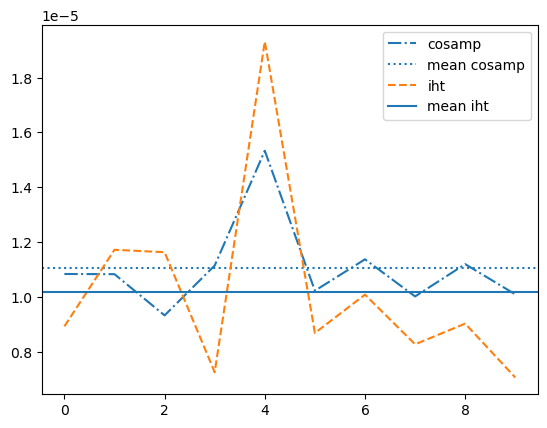

In [35]:
Y = np.dot(A,X[:,:10])
# CosampPKS
ErrCosampPKS = []
for j in range(Y.shape[1]):
    x = CosampPKS(Y[:,j],A,50,maxIter=100,showIfMaxIter=True)
    #看看误差.
    err = np.linalg.norm(x - X[:,j])
    ErrCosampPKS.append(err)
    print(j,'Err:',err)
else:
    print('Mean Err:',np.mean(ErrCosampPKS))

# IHTPKS
ErrIHTPKS = []
for j in range(Y.shape[1]):
    x = IHTPKS(Y[:,j],A,50,maxIter=100,showIfMaxIter=True)
    #看看误差.
    err = np.linalg.norm(x - X[:,j])
    ErrIHTPKS.append(err)
    print(j,'Err:',err)
else:
    print('Mean Err:',np.mean(ErrIHTPKS))

# OMPPKS
# ErrOMPPKS = []
# for j in range(Y.shape[1]):
#     x = OMPPKS(Y[:,j],A,maxIter=100,showIfMaxIter=True)
#     #看看误差.
#     err = np.linalg.norm(x - X[:,j])
#     ErrOMPPKS.append(err)
#     print(j,'Err:',err)
# else:
#     print('Mean Err:',np.mean(ErrOMPPKS))

plt.plot(ErrCosampPKS,ls='-.',label='cosamp')
plt.axhline(np.mean(ErrCosampPKS),ls=':',label='mean cosamp')
plt.plot(ErrIHTPKS,ls='--',label='iht')
plt.axhline(np.mean(ErrIHTPKS),ls='-',label='mean iht')
# plt.plot(ErrOMPPKS,label='omp')
plt.legend()

In [ ]:
# Test 待改20230402
# def test(Y,X,s,times=1000, func=IHTPKS, priorSuppRatio=0.2, SuppsReal=None, **kwargs):
#     """
#     Run `times` times of `func` function
#         given `Y`=[y1,...,yt], `X`=[x1,...,xt],
#         use `priorSuppRatio`(from 0 to 1) instead of `T0`,
#         `SuppsReal`: aranged by cols, if `None` then supps(X)(`s` needed),
#         and `**kwargs` as other keyword arguments.
    
#     Return the results in an array.
#     """
#     Results = []
#     if SuppsReal is None:
#         SuppsReal = np.zeros((s,X.shape[1])).astype('int')
#         for j in range(X.shape[1]):
#             SuppsReal[:,j] = np.argsort(np.abs(X[:,j]))[:-(s+1):-1] #兼容compressible signal.

#     for t in range(times):
#         T0 = np.random.choice(SuppsReal[:,t],int(round(s*priorSuppRatio,0)),replace=False)
#         Results.append(func(y=Y[:,t],xReal=X[:,t],T0=T0,s=s,**kwargs))
#     return Results

# -99|Exec! Debug area

In [16]:
len([])

0

In [17]:
np.array([]).dot([])

0.0

In [19]:
[1,2,3][:-2:-1]

[3]

In [22]:
list({1,3,2,4})

[1, 2, 3, 4]

In [23]:
{1,2} | {3,2}

{1, 2, 3}

In [26]:
a=np.array([1,2,3,0,0,-1])

In [30]:
1 - np.isclose(a+1e-12,0)

array([1, 1, 1, 0, 0, 1])